# Active Learning for Labeling of Electrochemical Data

## Gavin Hazen, Jose Lasso, Michael Pence, Sagar Chaudhary

First we will import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

Next we import the labeled dataset

In [ ]:
cv_df = pd.read_csv('labels.csv')[['c_cat','c_sub','kc','v','log_gamma','log_lambda','k0','filename','class']]
cv_df.head()


We select our features (log_gamma and log_lambda) and our labels (class)

In [ ]:
y = cv_df['class'].values
X = cv_df[['log_gamma','log_lambda']].values
classes = ['K','D','KS','KD','KG','KT']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)


Here we want to determine the best k-value for our KNN model that we will use as our estimator in our active learner. We standardize our features using StandardScaler, and have put that inside a pipeline. We iterate through k values of 2 through 50

In [ ]:
cvs_mean, cvs_std = [], []

k_values = np.arange(2,50)
folds = 10

cvs = np.zeros((folds,len(k_values)))

for n in range(len(k_values)):
    
    pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=k_values[n]))])
    pipe['knn'].classes_ = classes

    cvs[:,n] = cross_val_score(pipe, X_train, y_train, cv=folds)
    cvs_mean.append(np.mean(cvs[:,n]))
    cvs_std.append(np.std(cvs[:,n]))
    
cvs_mean, cvs_std = np.array(cvs_mean), np.array(cvs_std)

We fit our model using the optimal parameters obtained in the previous block

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=k_values[np.argmax(cvs_mean)]))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

Plotting our results from cross validation, and the confusion matrix of our model's predictions on the test set.

0.9612452107279694


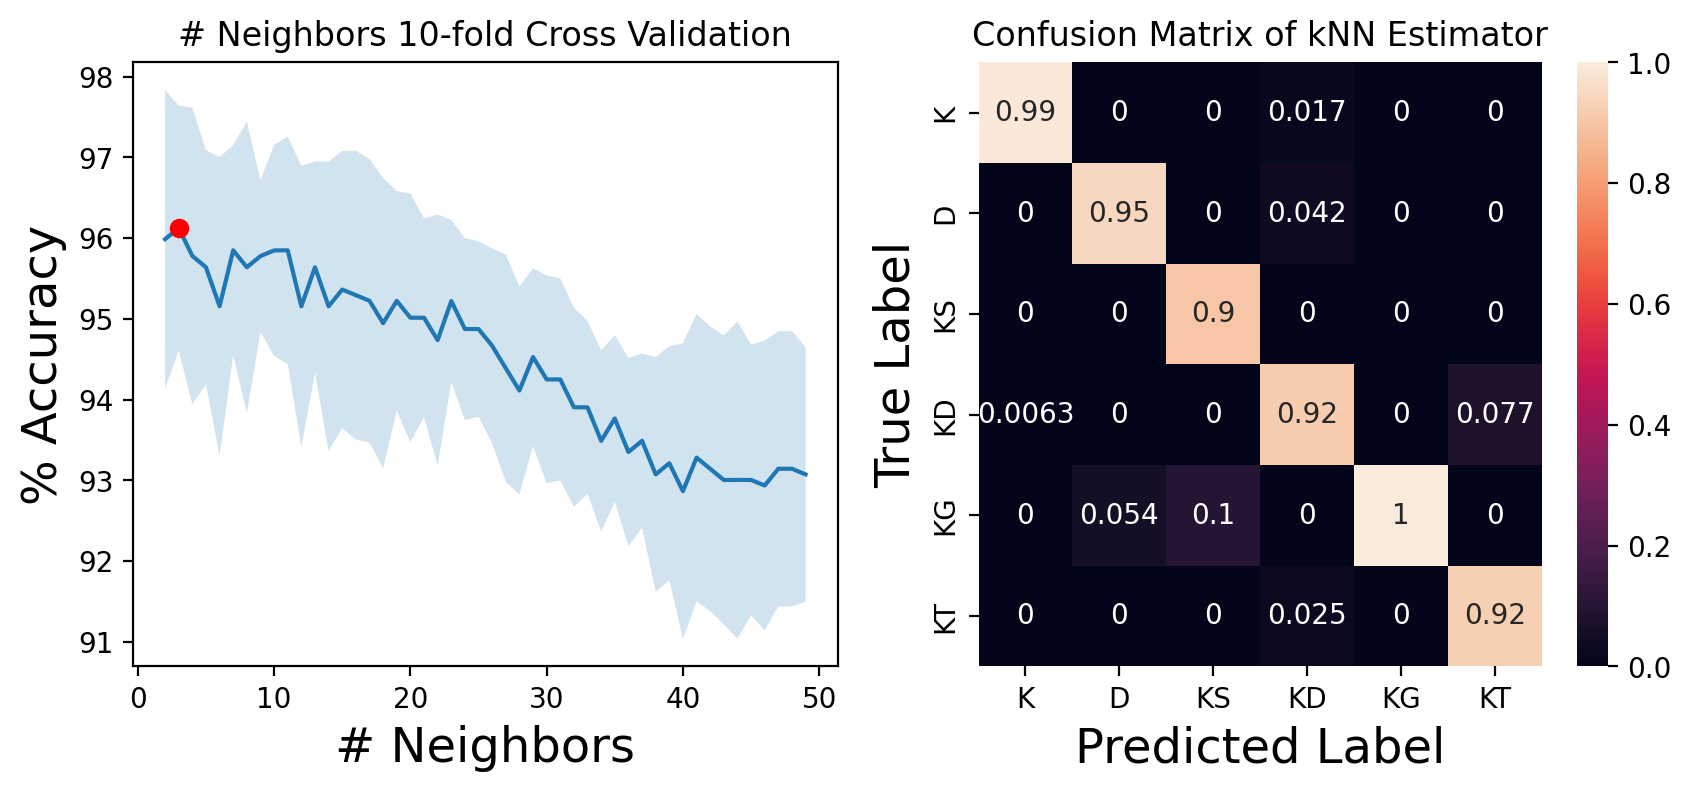

In [302]:
plt.figure(dpi=200,figsize=(10,4))
labelsize = 'xx-large'

plt.subplot(1,2,1)
plt.title('# Neighbors 10-fold Cross Validation')
plt.plot(k_values,cvs_mean*100, zorder=1)
plt.fill_between(k_values, (cvs_mean+cvs_std)*100, (cvs_mean-cvs_std)*100, alpha=0.2, zorder=1)
plt.scatter(k_values[np.argmax(cvs_mean)],np.max(cvs_mean)*100,c='red', zorder=2)
plt.xlabel('# Neighbors',fontsize=labelsize)
plt.ylabel('% Accuracy',fontsize=labelsize)

plt.subplot(1,2,2)
plt.title('Confusion Matrix of kNN Estimator')
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='pred'),
            annot=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Label',fontsize=labelsize)
plt.ylabel('True Label',fontsize=labelsize)

print(np.max(cvs_mean))

Now that we know what the fully trained model's accuracy is, we can begin testing active learning methods.

# Setting up an Active Learning workflow

Before testing the effect of uncertainty sampling, we first walk through how the base of our active learning script works

The first thing we want to do is setup our pool of data, and pull some initial points from it. Upon drawing our initial points we delete them from the pool

In [ ]:
n_init = 5

#setup pool
X_pool, y_pool = X_train, y_train

#draw initial points randomly, without replacement
init_idx = np.random.choice(range(X_pool.shape[0]), size=n_init, replace=False)
X_init, y_init = X_pool[init_idx], y_pool[init_idx]

#delete them from the pool
X_pool, y_pool = np.delete(X_pool, init_idx, axis=0), np.delete(y_pool, init_idx)

Next we need to establish our learner. Here we need three things: our estimator, our initial data, and a query strategy. We will use the 'pipe' estimator established before (a pipeline of StandardScaler and KNN with k value of 3) and we will use the X_init and y_init data from the above block as our training data. We set our query strategy as uncertainty sampling.

In [308]:
learner = ActiveLearner(
                    estimator=pipe,
                    X_training=X_init, y_training=y_init,
                    query_strategy=uncertainty_sampling
                )

Now we have setup our learner, and can begin active learning. We will define a number of query iterations we would like it to perform and then put those in a for loop. 

When we perform our query function, learner.query(), it will give us an index that we can use to select our label from the y_pool data. In real life this data would be provide by the oracle, but we simulate it here to make things easy to see.

Once we have our obtained label, we retrain our learner. The learner now has all of the previous training data and the recently queried point, and is refit to update the model.

We repeat this loop until we achieve sufficient performance, or until we run out of time/money/etc.. 

In [ ]:
n_queries = 50

for i in range(n_queries):

        query_idx, X_query = learner.query(X_pool)
        y_query = y_pool[query_idx]
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)

        learner.teach(
                        X=X_query,
                        y=y_query
                    )
        

We can then use the learner as we would any other sklearn estimator, using calls such as learner.predict()

Now we test the difference between an uncertainty sampling method and random sampling

# Uncertainty Sampling

Here we use the same workflow as above, but with more repetitions. We keep track of the accuracy on the withheld test set for each iteration so we can see how the model improves with each query.

In [304]:
unc_scores, unc_queries = [], []
n_init = 5
n_queries = len(X_train)-n_init
n_trials = 25

for loop in range(n_trials):
    score, queries = [], []

    X_pool, y_pool = X_train, y_train
    init_idx = np.random.choice(range(X_pool.shape[0]), size=n_init, replace=False)
    X_init, y_init = X_pool[init_idx],y_pool[init_idx]
    X_pool, y_pool = np.delete(X_pool, init_idx, axis=0),np.delete(y_pool, init_idx)

    learner = ActiveLearner(
                    estimator=pipe,
                    X_training=X_init, y_training=y_init,
                    query_strategy=uncertainty_sampling
                )

    for i in range(n_queries):

        query_idx, X_query = learner.query(X_pool)
        y_query = y_pool[query_idx]
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)

        learner.teach(
                        X=X_query,
                        y=y_query
                    )
        
        score.append(learner.score(X_test,y_test))
        queries.append(X_query)
        
    unc_scores.append(score)
    unc_queries.append(queries)

# Random Sampling

Here we do the same as above, but with random sampling. To do this we can setup the exact learner we did above, but now we simply don't use its learner.query() to obtain the index of the next query position. Instead we perform np.random.choice to randomly sample. We do however perform learner.teach() to update the learner with the randomly sampled data.

In [305]:
rand_scores, rand_queries = [], []
n_init = 5
n_queries = len(X_train)-n_init
n_trials = 25

for loop in range(n_trials):

    score, queries = [], []

    X_pool, y_pool = X_train, y_train
    init_idx = np.random.choice(range(X_pool.shape[0]), size=n_init, replace=False)
    X_init, y_init = X_pool[init_idx],y_pool[init_idx]
    X_pool, y_pool = np.delete(X_pool, init_idx, axis=0),np.delete(y_pool, init_idx)

    learner = ActiveLearner(
                    estimator=pipe,
                    X_training=X_init, y_training=y_init,
                    query_strategy=uncertainty_sampling
                )

    for i in range(n_queries):

        query_idx = np.random.choice(range(X_pool.shape[0]), size=1, replace=False)
        X_query = X_pool[query_idx]
        y_query = y_pool[query_idx]
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)

        learner.teach(
                        X=X_query ,
                        y=y_query
                    )
        
        score.append(learner.score(X_test,y_test))
        queries.append(X_query)
        
    rand_scores.append(score)
    rand_queries.append(queries)


# Plotting

Now we can plot the difference between both methods, as well as where on our zone diagram the uncertainty sampling algorithm choose to sample

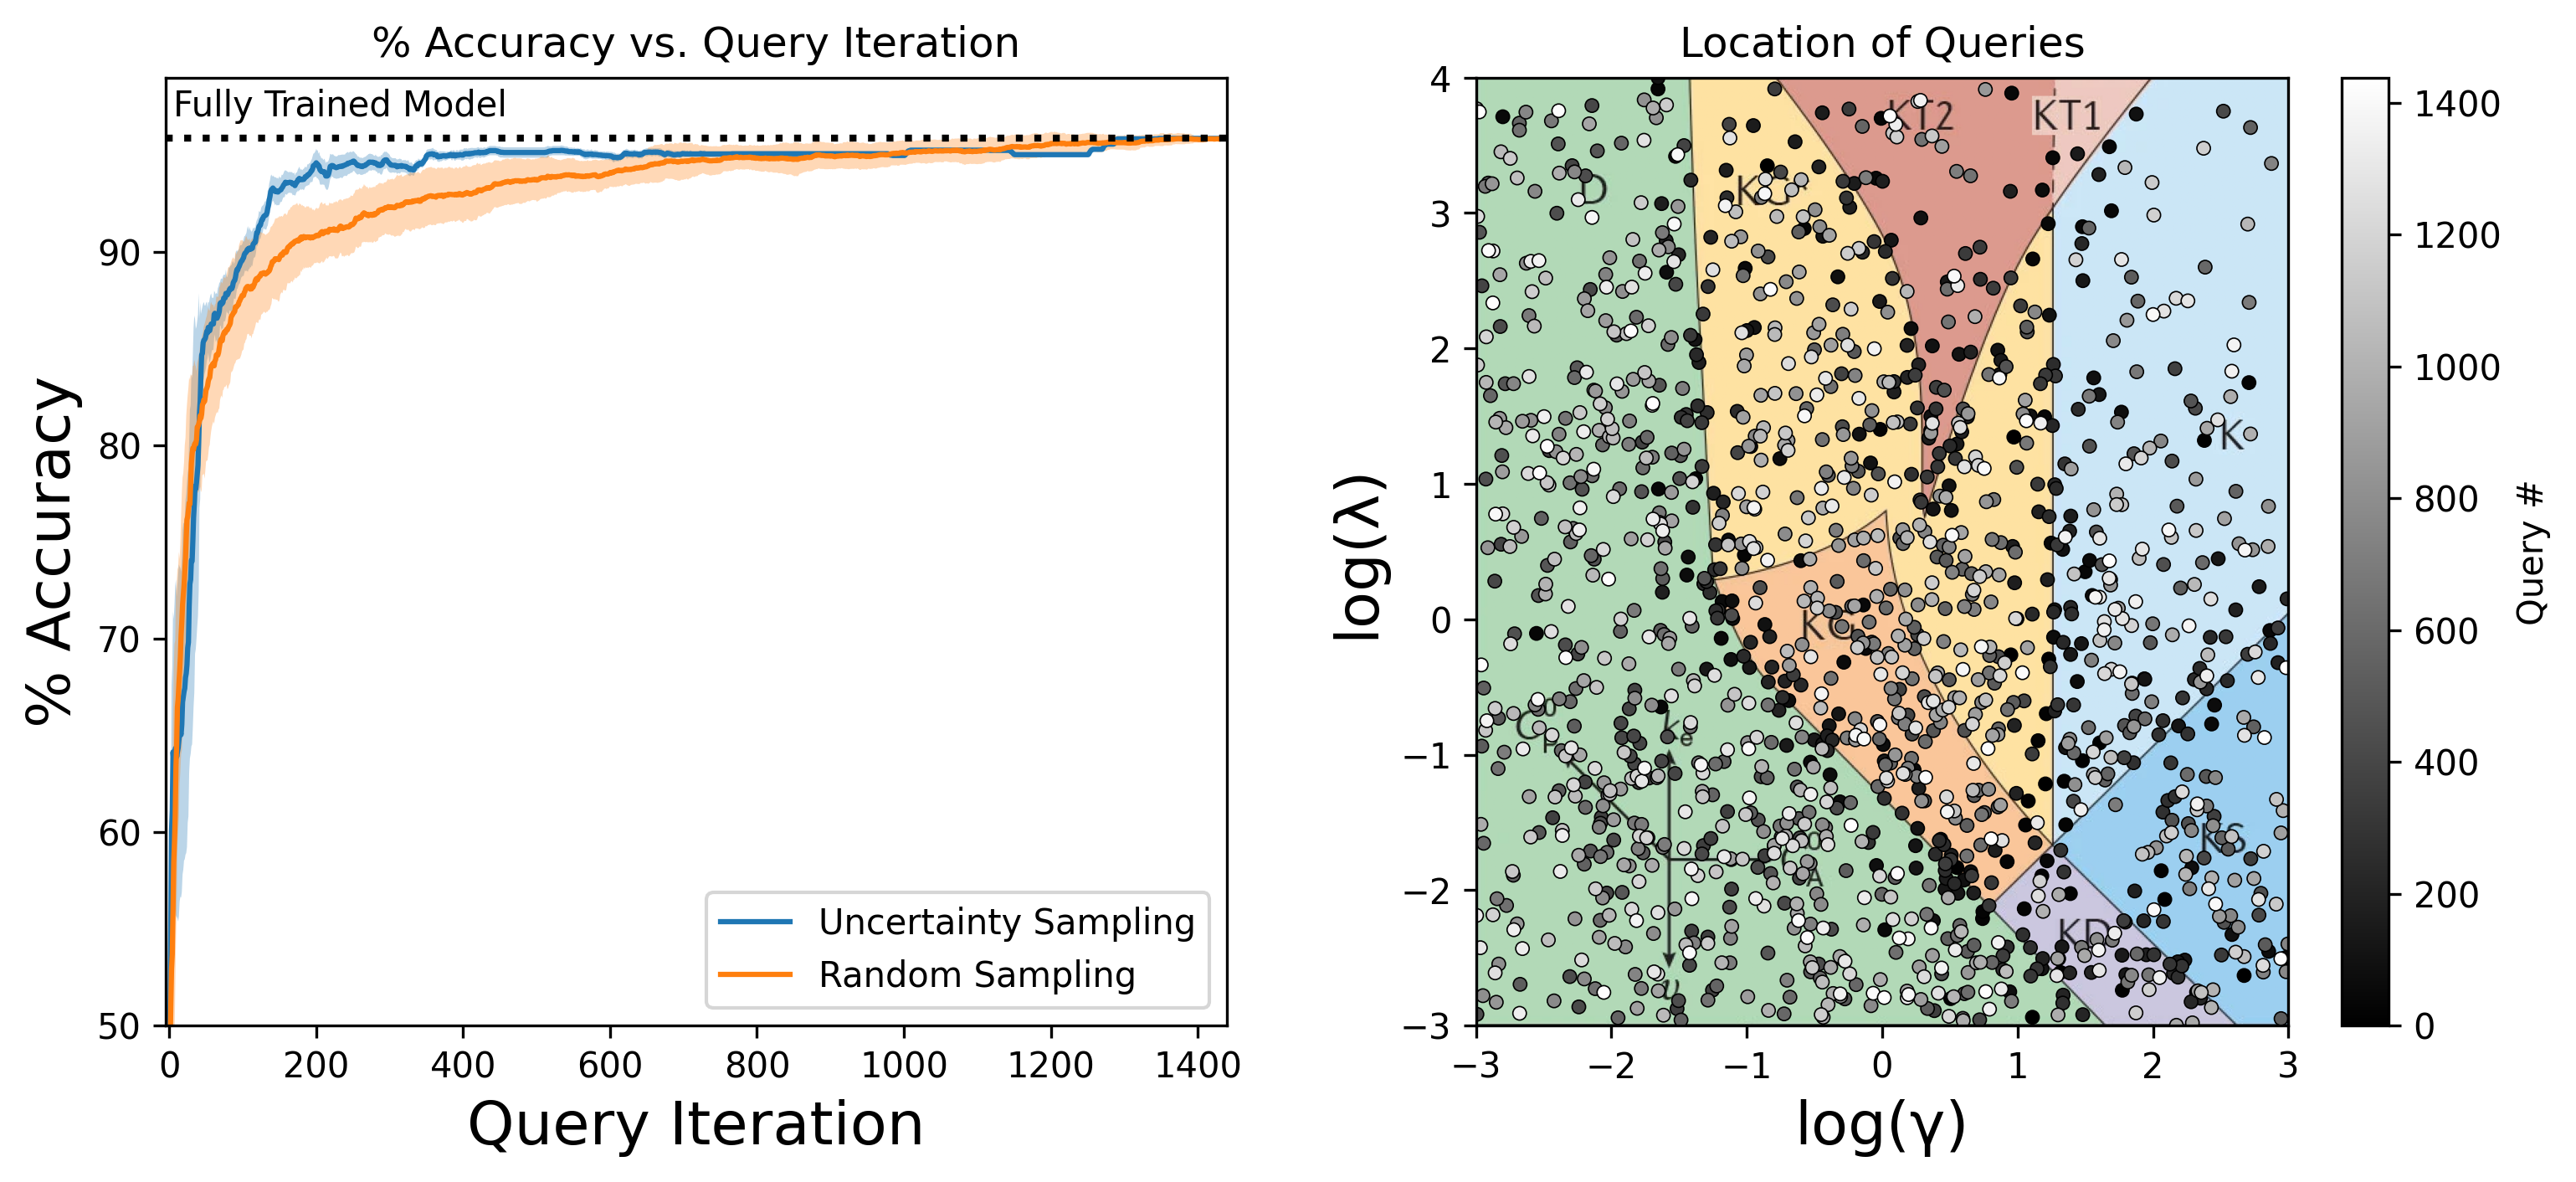

In [306]:
labelsize = 'xx-large'

query_num = 4
plt.figure(figsize=(12,5),dpi=300)

plt.subplot(1,2,1)
plt.title('% Accuracy vs. Query Iteration')
mean = np.mean(unc_scores,axis=0)*100
std = np.std(unc_scores,axis=0)*100
mean2 = np.mean(rand_scores,axis=0)*100
std2 = np.std(rand_scores,axis=0)*100
plt.plot(range(len(mean)),mean)
plt.plot(range(len(mean2)),mean2)
plt.fill_between(range(len(mean)),mean+std,mean-std,alpha=0.3)
plt.fill_between(range(len(mean2)),mean2+std2,mean2-std2,alpha=0.3)
plt.axhline((accuracy_score(y_test, y_pred)*100), color='black', linewidth = 2, linestyle='dotted')
plt.xlabel('Query Iteration',fontsize=labelsize)
plt.ylabel('% Accuracy',fontsize=labelsize)
plt.annotate('Fully Trained Model', (5,97))
plt.ylim(50,99)
plt.xlim(-5,1440)
plt.legend(['Uncertainty Sampling','Random Sampling'], loc='lower right', fontsize='medium')

plt.subplot(1,2,2)
plt.title('Location of Queries')
im = plt.imread('image.png')
plt.imshow(im,extent=[-3,3,-3,4],alpha=1)

alpha = np.arange(np.shape(unc_queries)[1])/np.shape(unc_queries)[1]
plt.scatter(np.array(unc_queries)[query_num,:,0,0],
            np.array(unc_queries)[query_num,:,0,1],
            c=np.arange(np.shape(unc_queries)[1]),
            cmap='gray',
            edgecolors='black',
            linewidth=0.4,
            s=15,
            alpha=1)
plt.xlabel(u'log(γ)',fontsize=labelsize)
plt.ylabel(u'log(λ)',fontsize=labelsize)
plt.colorbar(label='Query #')

plt.show()

It is clear that after some time uncertainty sampling begins to outperform random sampling. Intrestingly we can also get an intuitive feel for how it samples by looking at the zone diagram. It initially picks points on the edge of two classes, which makes sense as those would be the most uncertain regions. As those points get use up it begins to sample more broadly across the feature space.

We plot the inset to see in more detail the point where uncertainty sampling begins to outperform random sampling.

(0.0, 100.0)

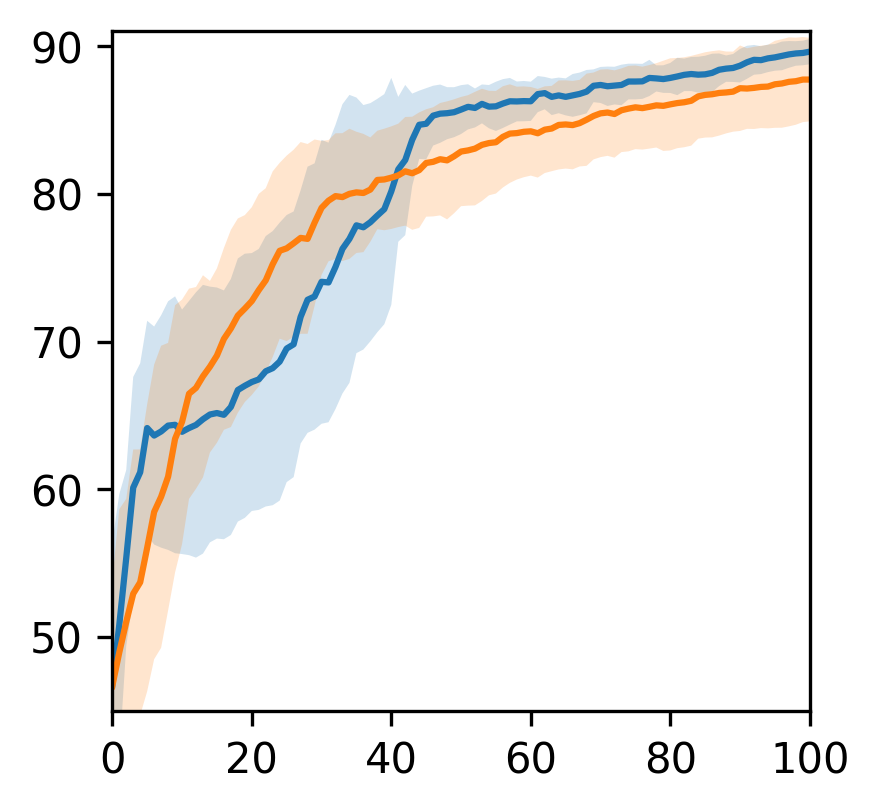

In [307]:
plt.figure(figsize=(3,3),dpi=300)
mean = np.mean(unc_scores,axis=0)*100
std = np.std(unc_scores,axis=0)*100
mean2 = np.mean(rand_scores,axis=0)*100
std2 = np.std(rand_scores,axis=0)*100
plt.plot(range(len(mean)),mean)
plt.plot(range(len(mean2)),mean2)
plt.fill_between(range(len(mean)),mean+std,mean-std,alpha=0.2)
plt.fill_between(range(len(mean2)),mean2+std2,mean2-std2,alpha=0.2)
plt.ylim(45,91)
plt.xlim(0,100)